In [399]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.path as mpath
import plotly.express as px
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, CubicSpline, interp1d, PchipInterpolator
import os
from tqdm import tqdm

In [36]:
keys = ['nodes', 'elements', 'edges', 'flow']
data_files = {}

for key in keys:
    files = os.listdir('TrainingData/LowReFlowData/dataset_shapes_gcnn/' + key + '/')
    files = [f for f in files if f.endswith('.csv')]
    code = [int(f.split('_')[1].split('.')[0]) for f in files]
    data_files[key+'_files'] = files
    data_files[key+'_code'] = code
    

In [133]:
dataO = []

for i in tqdm(range(len(data_files['nodes_files']))):
    nodes = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/nodes/' + data_files['nodes_files'][i])
    elements = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/elements/' + data_files['elements_files'][i])
    edges = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/edges/' + data_files['edges_files'][i])
    flow = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/flow/' + data_files['flow_files'][i])
    dataO.append({'nodes':nodes, 'elements':elements, 'edges':edges, 'flow':flow})

100%|██████████| 3973/3973 [00:14<00:00, 275.81it/s]


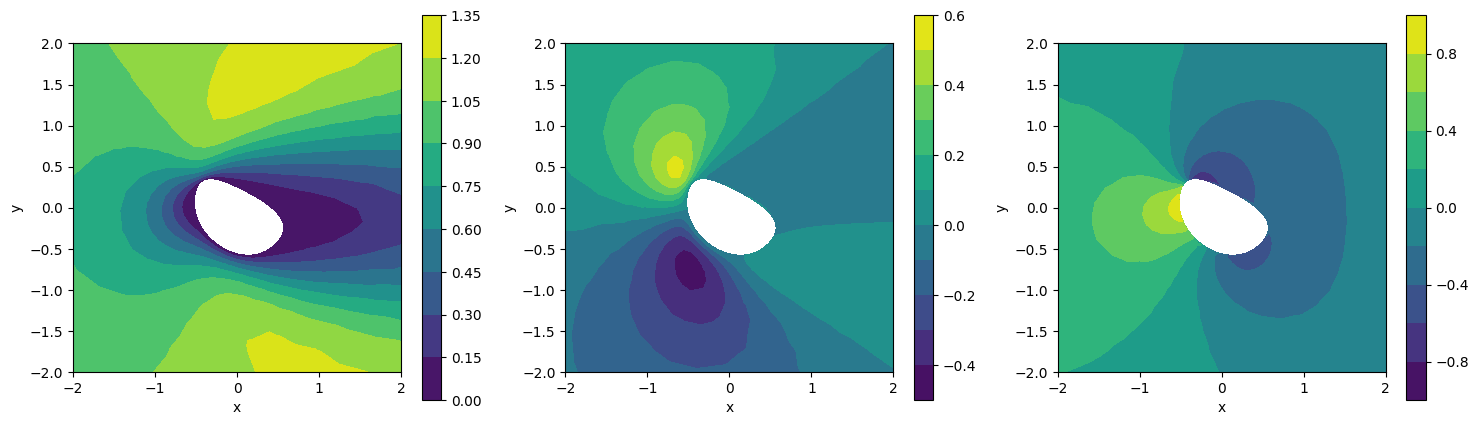

In [57]:
def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    plt.figure(figsize=(6*r,5))
    for i in range(r):
        plt.subplot(1,r,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
    return 

PlotFEMsolution(data[0][0]['nodes'].values, data[0][0]['elements'].values, data[0][0]['flow'].values)

In [326]:
def computeLengthAlongCurve(nodesB):
    dl = np.sqrt(((nodesB[1:]-nodesB[:-1])**2).sum(1))
    l = np.cumsum(dl)
    l = np.concatenate([[0],l],0)
    return l

def GetNormals(nodesB, distanceCurves):
    nodesB_expand = np.concatenate([nodesB[-2:-1],nodesB,nodesB[1:2]],0)
    alpha_expand = np.concatenate([[distanceCurves[-2]-distanceCurves[-1]],distanceCurves,[distanceCurves[-1]+distanceCurves[1]]],0).reshape(-1,1)
    dalpha = alpha_expand[2:]-alpha_expand[1:-1]
    dalpha1 = alpha_expand[1:-1]-alpha_expand[0:-2]
    c = dalpha1/dalpha
    dNodesdAlpha = c/((c+1)*dalpha) * nodesB_expand[2:] + (1-c)/(c*dalpha) * nodesB_expand[1:-1] - 1/(c*(c+1)*dalpha) * nodesB_expand[0:-2]
    normal = np.stack([dNodesdAlpha[:,1],-dNodesdAlpha[:,0]],axis=1)
    normal = normal/np.sqrt((normal**2).sum(1)).reshape(-1,1)
    normal[-1] = normal[0]
    return normal

nodes = dataO[0]['nodes']
elements = dataO[0]['elements']
flow = dataO[0]['flow']

data = {}

# Domain data
data['nodes'] = nodes[['x','y']].values
data['elements'] = elements[['V1','V2','V3']].values
data['solution'] = flow[['u','v','p']].values

# Boundary curve data
idxCurve2 = nodes[nodes['Object']==0].index
idxCurve2 = np.concatenate([idxCurve2,idxCurve2[0:1]],0)
idxCurve1 = np.concatenate([
    nodes[nodes['y']==-2].sort_values(by='x',ascending=True)[['x','y']].index,
    nodes[nodes['x']==2].sort_values(by='y',ascending=True)[['x','y']].index[1:],
    nodes[nodes['y']==2].sort_values(by='x',ascending=False)[['x','y']].index[1:],
    nodes[nodes['x']==-2].sort_values(by='y',ascending=False)[['x','y']].index[1:],
])
data['idxCurves'] = [idxCurve1,idxCurve2]
data['distanceCurves'] = []
data['nodesCurves'] = []
data['lengthCurves'] = []
data['normalCurves'] = []
for i in range(len(data['idxCurves'])):
    nodesB = data['nodes'][data['idxCurves'][i]]
    data['distanceCurves'].append(computeLengthAlongCurve(nodesB))
    data['nodesCurves'].append(nodesB)
    data['lengthCurves'].append(data['distanceCurves'][i][-1])
    data['normalCurves'].append(GetNormals(nodesB,data['distanceCurves'][i]))

data['idxCorner'] = nodes[nodes['x'].isin([-2,2]) & nodes['y'].isin([-2,2])].index.values.tolist()
data['idxCurveCorner'] = [0,0,0,0]
data['idxCornerCurve'] = [np.where(data['idxCurves'][data['idxCurveCorner'][i]] == data['idxCorner'][i])[0][0] for i in range(len(data['idxCorner']))]
data['distaceCornerCurve'] = [data['distanceCurves'][data['idxCurveCorner'][i]][data['idxCornerCurve'][i]] for i in range(len(data['idxCorner']))]

In [397]:
class IsInDomain:
    def __init__(self, nodesCurves):
        self.loops = [mpath.Path(nodesCurves[i]) for i in range(len(nodesCurves))]
        
    def __call__(self, points):
        return np.logical_and(self.loops[0].contains_points(points),np.logical_not(np.array([loop.contains_points(points) for loop in self.loops[1:]]).any(0)))

class Interp2DInDomain:
    def __init__(self,points,vals,isInDomainF):
        self.interpF = CloughTocher2DInterpolator(points,vals)
        self.inInDomainF = isInDomainF
    
    def __call__(self,points):
        vals = self.interpF(points)
        vals[~self.inInDomainF(points)] = np.nan
        return vals
    
class Interp1DPeriodic:
    def __init__(self, x, y, kind = 'linear'):
        self.x = x
        self.y = y
        self.kind = kind
        self.spline = interp1d(self.x,self.y,kind=self.kind,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
class Interp1DPchipPeriodic:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.spline = PchipInterpolator(self.x,self.y,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    


valSliceE = slice(0,3)
valSliceD = slice(0,2)

data['isInDomainF'] = IsInDomain(data['nodesCurves'])
data['interpSE'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceE],data['isInDomainF'])
data['interpSD'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceD],data['isInDomainF'])

data['solutionB'] = []
data['interpBS'] = []
data['interpBN'] = []
data['interpBC'] = []
for i in range(len(data['idxCurves'])):
    data['solutionB'].append(data['solution'][data['idxCurves'][i]])
    data['interpBS'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['solutionB'][i]))
    data['interpBN'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['normalCurves'][i]))
    data['interpBC'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['nodesCurves'][i]))



(-2.2, -1.8)

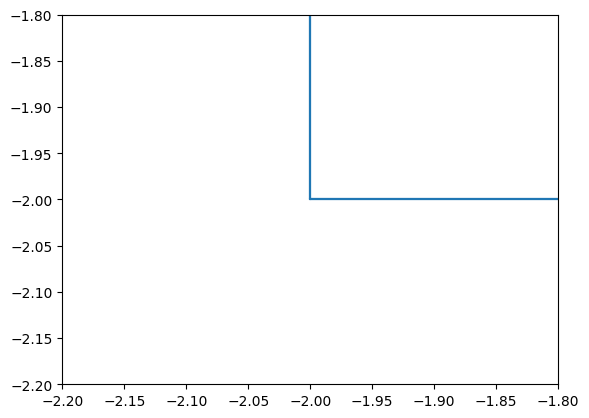

In [396]:
plt.plot(y[:,0],y[:,1])
plt.ylim([-2.2,-1.8])
plt.xlim([-2.2,-1.8])

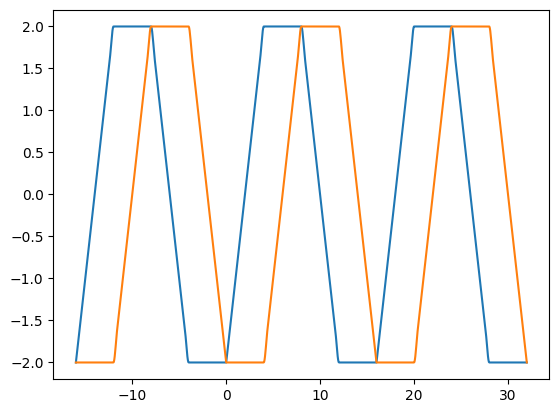

In [394]:
i = 0
x = np.linspace(-data['lengthCurves'][i],data['lengthCurves'][i]*2,1000)
y = data['interpBC'][i](x)
plt.plot(x,y)

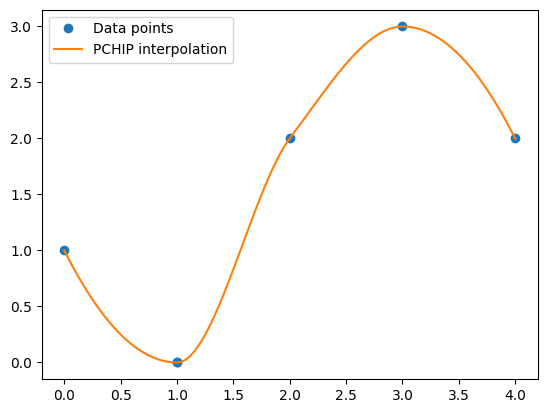

In [354]:
import numpy as np
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt

# Example data points
x = np.array([0, 1, 1.001, 2, 3, 4])
y = np.array([1, 0, 0, 2, 3, 2])

# Create the PCHIP interpolator
pchip = PchipInterpolator(x, y)

# Generate points for plotting
x_dense = np.linspace(min(x), max(x), 1000)
y_dense = pchip(x_dense)

# Plot the original points and the interpolated curve
plt.plot(x, y, 'o', label='Data points')
plt.plot(x_dense, y_dense, '-', label='PCHIP interpolation')
plt.legend()
plt.show()

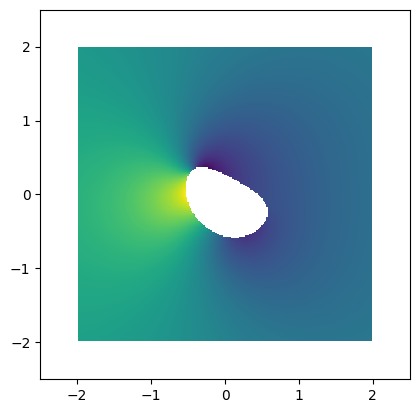

In [314]:
n = 300
x = np.linspace(-2.5,2.5,n)
X,Y = np.meshgrid(x,x)
points = np.stack([X.flatten(),Y.flatten()],1)
valsE = data['interpSE'](points).reshape(n,n,-1)
valsD = data['interpSD'](points).reshape(n,n,-1)
plt.imshow(valsE[:,:,2],extent=[-2.5,2.5,-2.5,2.5],origin='lower')
plt.show()

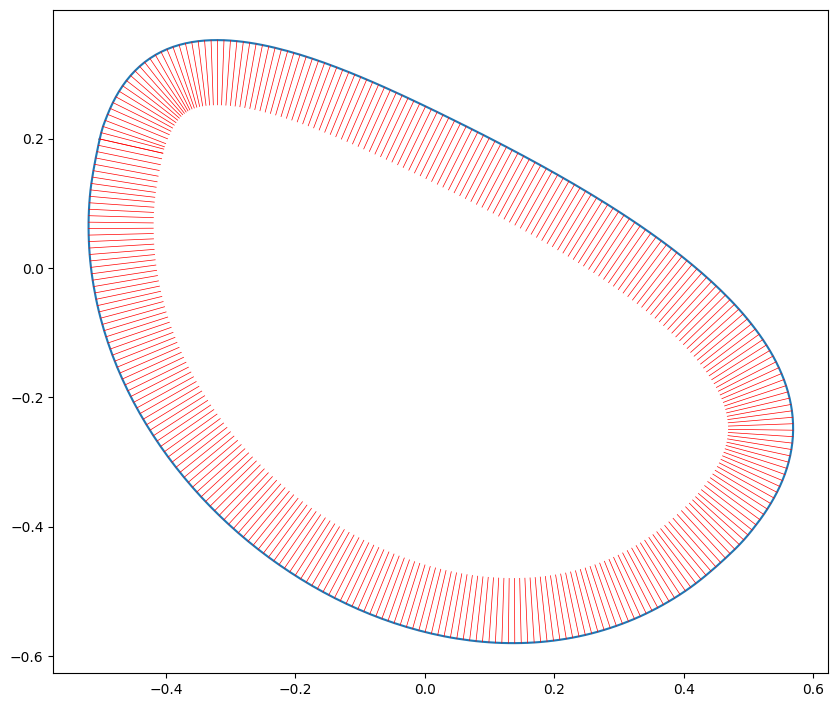

In [383]:
nodes = data['nodes']
nodesB1 = nodes[idxCurve1]
normals1 = data['normalCurves'][0]
nodesB2 = nodes[idxCurve2]
normals2 = data['normalCurves'][1]
plt.figure(figsize=(10,10))
# plt.plot(nodesB1[:,0],nodesB1[:,1])
# k = 0.1
# for i in range(nodesB1.shape[0]):
#     plt.plot([nodesB1[i,0],nodesB1[i,0]+k*normals1[i,0]],[nodesB1[i,1],nodesB1[i,1]+k*normals1[i,1]],'r',linewidth=0.5)
plt.plot(nodesB2[:,0],nodesB2[:,1])
for i in range(nodesB2.shape[0]):
    plt.plot([nodesB2[i,0],nodesB2[i,0]+k*normals2[i,0]],[nodesB2[i,1],nodesB2[i,1]+k*normals2[i,1]],'r',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')